# Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import combinations
from scipy.special import softmax
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
import datetime
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder, RobustScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline,  FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.base import clone, TransformerMixin, ClassifierMixin, BaseEstimator
from sklearn import set_config
from tensorflow import keras
import catboost as cb
import scipy
from colorama import Style, Fore
import optuna
set_config(transform_output='pandas')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nwds-batted-balls/sample_submission.csv
/kaggle/input/nwds-batted-balls/train.csv
/kaggle/input/nwds-batted-balls/test.csv


In [2]:
def reduce_mem(df: pd.DataFrame):
    "This method reduces memory for numeric columns in the dataframe";

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"];
    start_mem = df.memory_usage().sum() / 1024**2;

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min();
            c_max = df[col].max();

            if "int" in str(col_type):
                if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  

    end_mem = df.memory_usage().sum() / 1024**2

    print(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
    return df;

# Load Data

In [3]:
%%time
train = pd.read_csv('/kaggle/input/nwds-batted-balls/train.csv',index_col='uid')
test =  pd.read_csv('/kaggle/input/nwds-batted-balls/test.csv',index_col='uid')

CPU times: user 435 ms, sys: 61 ms, total: 496 ms
Wall time: 695 ms


In [4]:
train.shape, test.shape

((50000, 40), (14220, 38))

In [5]:
train.drop('outcome',axis=1,inplace=True)

In [6]:
pd.concat([train,test],axis=1).duplicated().any().any()

False

In [7]:
cat_features = test.select_dtypes(include='O').columns.tolist()
initial_features = list(test.columns)
for feature in initial_features:
    if feature in cat_features:    
        categories = sorted(set(test[feature].dropna()))
        dtype = pd.CategoricalDtype(categories=categories, ordered=False)
        print(sum(~np.isin(test[feature].unique(),train[feature].unique())))
        print(test[feature].unique()[~np.isin(test[feature].unique(),train[feature].unique())])
        train.loc[~train[feature].isin(categories),feature] = np.nan
        train[feature] = train[feature].astype(dtype)     
        test[feature] = test[feature].astype(dtype)

1
['CS']
0
[]
1
['Slow Curve']


In [8]:
initial_features = list(test.columns)

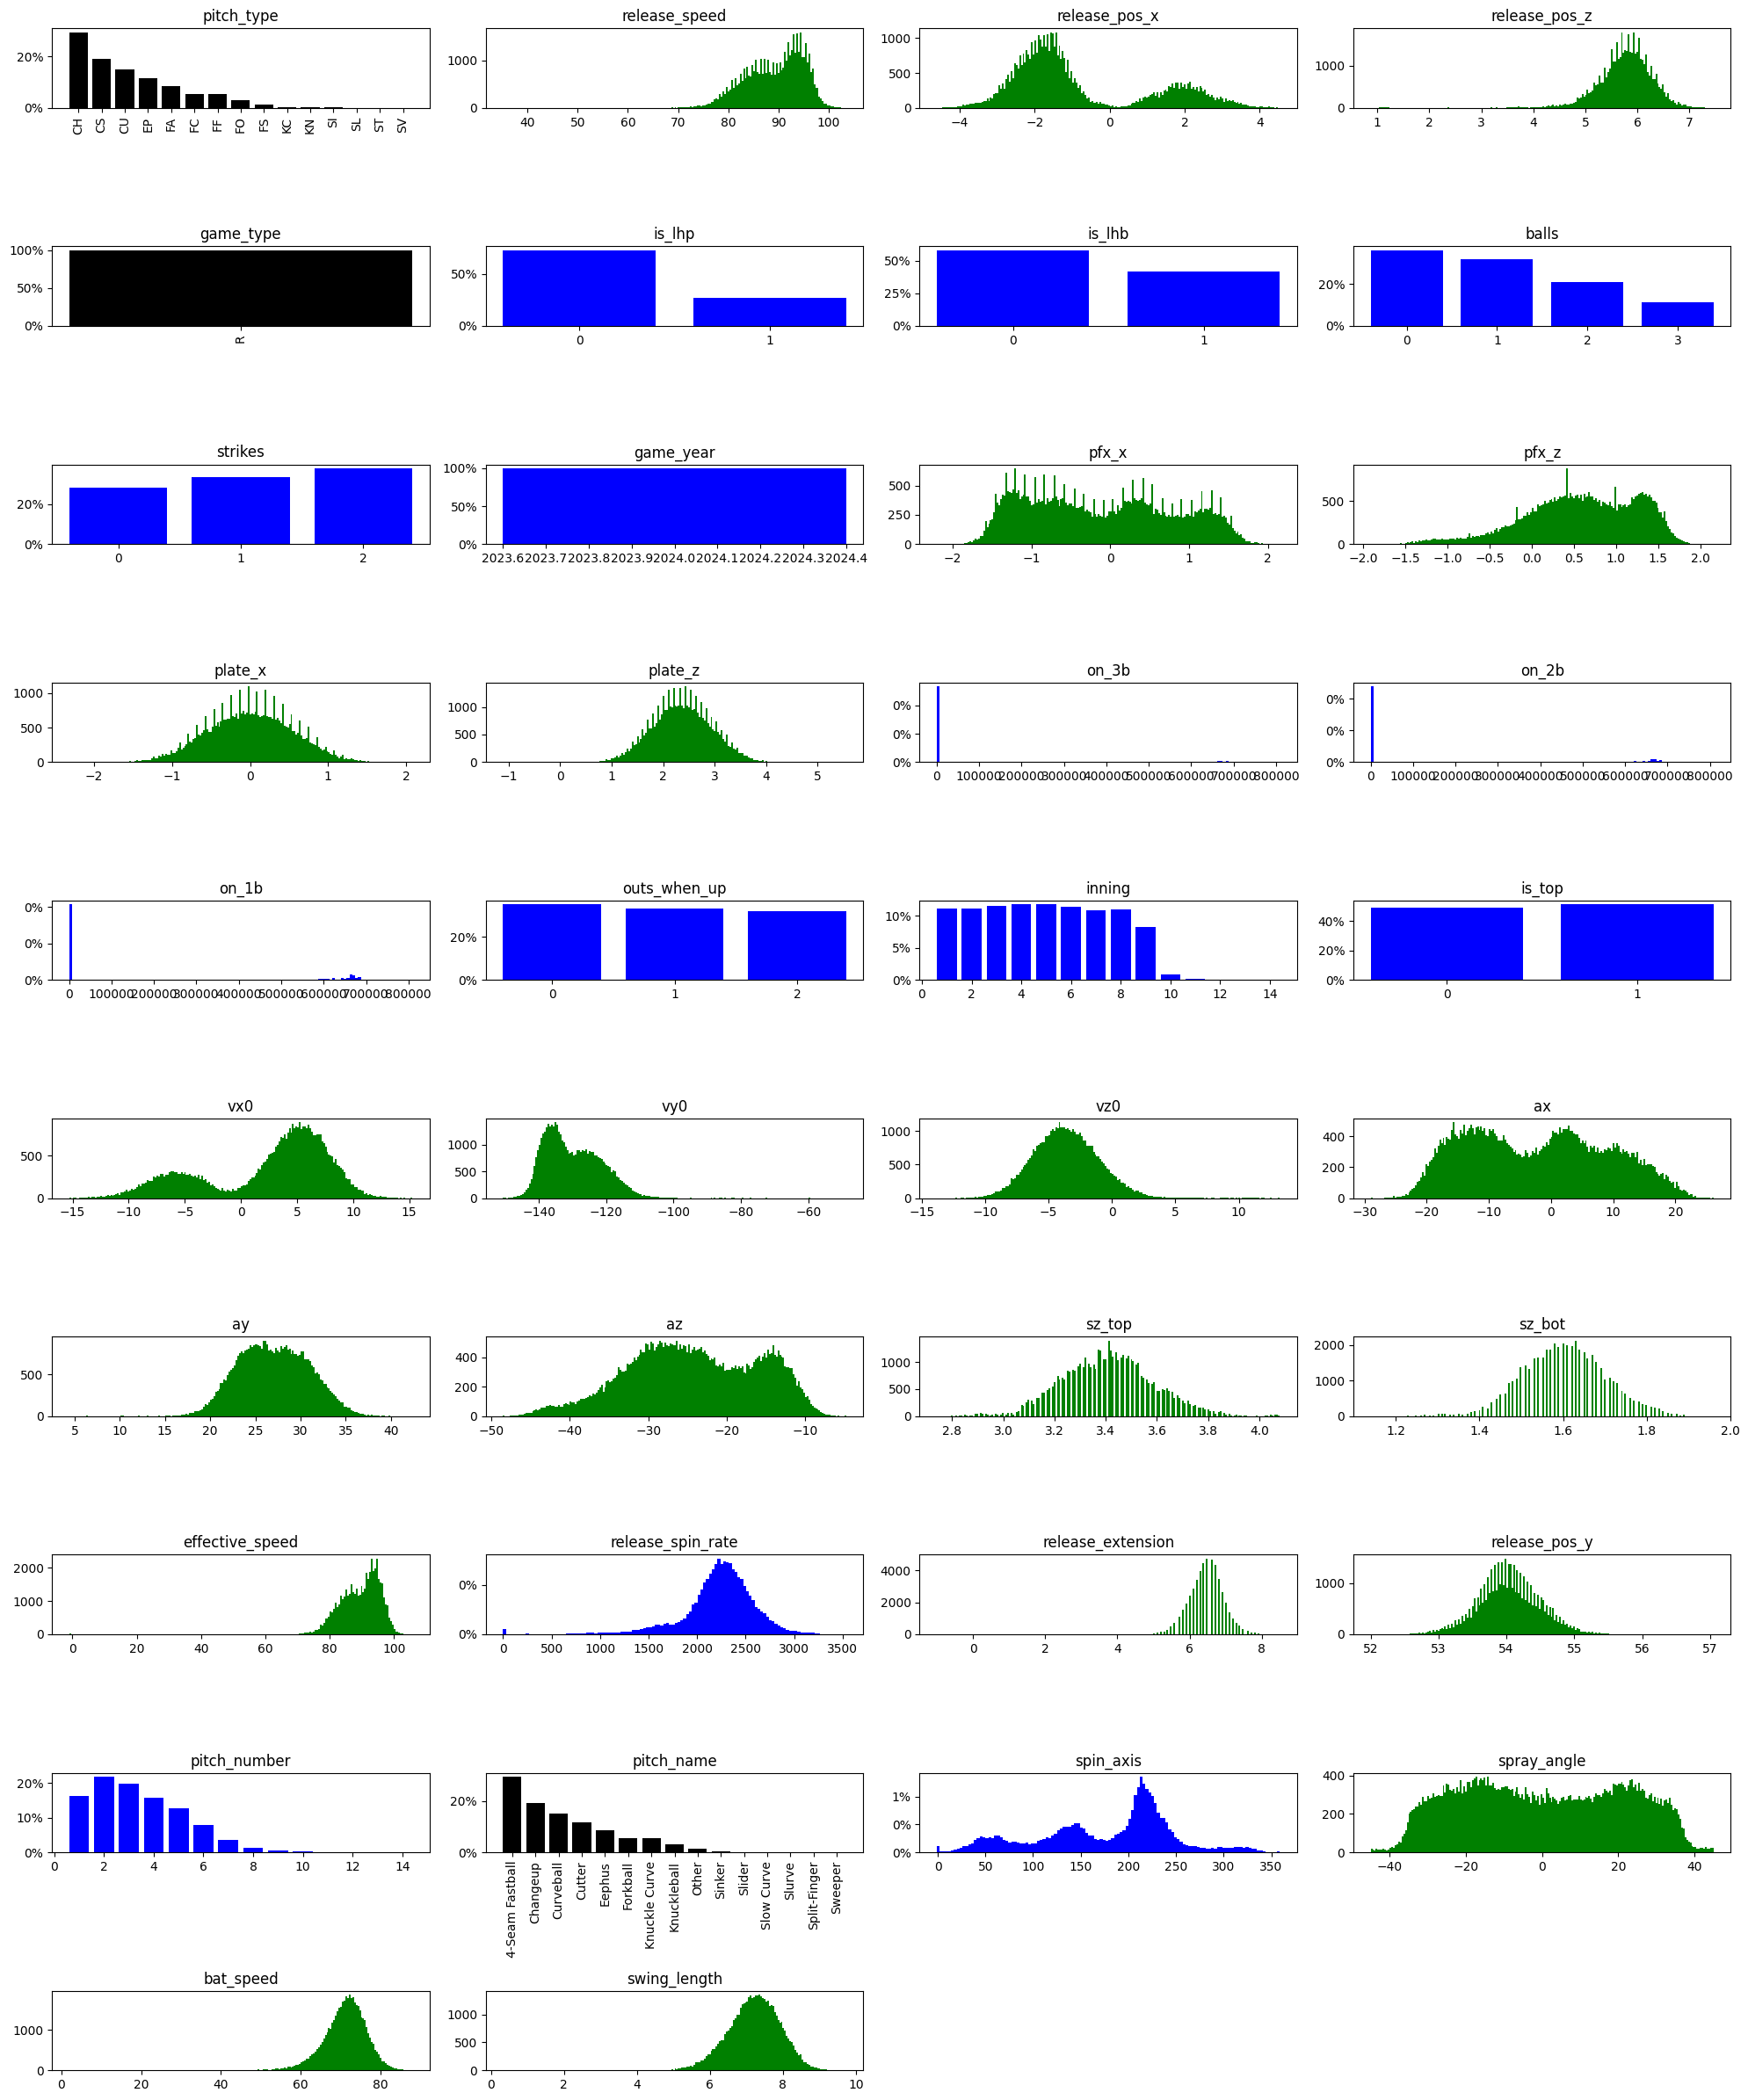

CPU times: user 15.7 s, sys: 329 ms, total: 16 s
Wall time: 15.7 s


In [9]:
%%time
fig, axs = plt.subplots(10,4, figsize=(20,4*6))
for col, ax in zip(initial_features,axs.ravel()):
    if train[col].dtype=='float':
        ax.hist(train[col],color='g',bins=200) 
#         ax.text(0.95,0.95,f'skew: {train[col].skew()}', transform=ax.transAxes,
#                 fontsize=12, verticalalignment='top', horizontalalignment='right')
    elif train[col].dtype=='category':
        vc =train[col].value_counts()/len(train)
        ax.bar(vc.index,vc,color='black')
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=15:
            ax.set_xticks(np.arange(len(train[col].dtype.categories)), train[col].dtype.categories,rotation=90)
        
        else:
            ax.set_xticks([])
    else: 
        vc = train[col].value_counts()/len(train)
        
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=30:
            ax.bar(vc.index, vc, color='blue')            
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        else:
            ax.hist(train[col],color='blue',bins=120,density=True)            
    ax.set_title(f'{col}')
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False)
plt.tight_layout()    
#plt.subplots_adjust(hspace=0.5)
plt.show()

* game_year, game_type has only 1 single value, so we will not use it
* we do not have duplicate values


In [10]:
drop_cols = ['game_year','game_type']
target = 'outcome_code'

In [11]:
train.drop(drop_cols,axis=1,inplace=True)
test.drop(drop_cols,axis=1,inplace=True)
cat_features = test.select_dtypes(include='category').columns.tolist()
initial_features = list(test.columns)

# Target

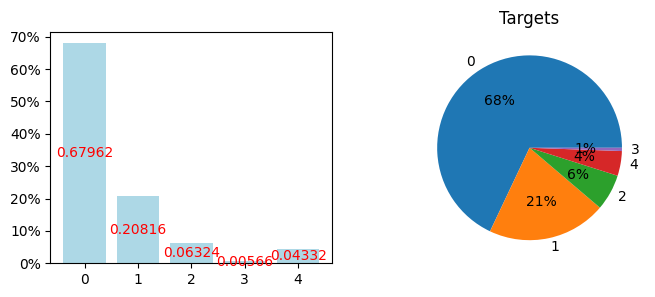

In [12]:
_, axs = plt.subplots(1,2, figsize=(8,3))
ax = axs.ravel()
vc = train[target].value_counts()/len(train)
ax[0].bar(vc.index,vc,color='lightblue')
ax[0].bar_label(ax[0].containers[0], label_type='center', color='red')
ax[0].yaxis.set_major_formatter('{x:.0%}')
vc = train[target].value_counts()
ax[1].pie(vc,labels=vc.index,autopct='%.0f%%')
plt.title('Targets');

# Feature Engineering

* Based on this [notebook](https://www.kaggle.com/code/michaelsemenoff/ensemble-new-hitting-features)

In [13]:
for df in [train,test]:
    # first new features from initial nb
    df['pitch_speed_diff'] = df['release_speed'] - df['effective_speed']
    df['horizontal_movement'] = df['pfx_x'] * df['release_extension']
    df['vertical_movement'] = df['pfx_z'] * df['release_extension']
    df['pitch_location'] = np.sqrt(df['plate_x']**2 + df['plate_z']**2)
    df['count_pressure'] = df['balls'] - df['strikes'] + 1
    df['bat_pitch_speed_ratio'] = df['bat_speed'] / df['release_speed']
    df['swing_efficiency'] = df['bat_speed'] / df['swing_length']
    df['movement_complexity'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    df['release_angle'] = np.arctan2(df['release_pos_z'], df['release_pos_x'])
    df['approach_angle'] = np.arctan2(df['vz0'], np.sqrt(df['vx0']**2 + df['vy0']**2))
    df['spin_efficiency'] = np.abs(np.sin(np.radians(df['spin_axis'])))
    df['magnus_effect'] = df['release_spin_rate'] * df['movement_complexity']
    df['break_time'] = df['release_extension'] / df['effective_speed']
    df['tunneling_time'] = 0.15 * df['release_speed'] / df['movement_complexity']
    df['stance_advantage'] = ((df['is_lhp'] == 1) & (df['is_lhb'] == 0)) | ((df['is_lhp'] == 0) & (df['is_lhb'] == 1))
    df['pitch_speed_change'] = df.groupby('pitch_number')['release_speed'].diff()
    df['horizontal_change'] = df.groupby('pitch_number')['pfx_x'].diff()
    df['vertical_change'] = df.groupby('pitch_number')['pfx_z'].diff()
    df['baserunner_pressure'] = df['on_1b'] + 2*df['on_2b'] + 3*df['on_3b']
    df['late_inning_pressure'] = (df['inning'] >= 7).astype(int)
    df['release_x_deviation'] = df['release_pos_x'] - df['release_pos_x'].mean()
    df['release_z_deviation'] = df['release_pos_z'] - df['release_pos_z'].mean()
    df['relative_height'] = (df['plate_z'] - df['sz_bot']) / (df['sz_top'] - df['sz_bot'])
    df['is_strike'] = ((df['plate_x'].between(-0.7083, 0.7083)) & 
                       (df['relative_height'].between(0, 1))).astype(int)
    df['contact_quality'] = df['bat_speed'] * np.cos(np.radians(df['spray_angle']))

    # New hitting-focused features in 2nd nb
    df['bat_to_pitch_speed_ratio'] = df['bat_speed'] / df['effective_speed']
    df['swing_plane_efficiency'] = np.cos(np.radians(df['spray_angle'])) / df['swing_length']
    df['contact_zone'] = np.arctan2(df['plate_z'], df['plate_x']) + df['spray_angle']
    df['swing_decision_time'] = df['effective_speed'] / df['swing_length']
    df['power_potential'] = df['bat_speed'] * np.abs(np.sin(np.radians(df['spray_angle'])))
    df['plate_discipline_index'] = df['is_strike'] * df['swing_efficiency']
    df['bat_control'] = df['bat_speed'] / df['swing_length']
    df['exit_velocity_estimate'] = (df['bat_speed'] + df['effective_speed']) * 0.5
    df['launch_angle_estimate'] = df['spray_angle'] * 0.6  # Assuming correlation between spray angle and launch angle
    df['sweet_spot_probability'] = 1 / (1 + np.exp(-(df['bat_speed'] - 70) / 10)) * (1 - np.abs(df['swing_length'] - 24) / 24)

    # New other features used in current leaderboard score

    # Exit velocity to launch angle ratio
    df['exit_velocity_launch_angle_ratio'] = df['exit_velocity_estimate'] / (df['launch_angle_estimate'].abs() + 1)

    # Swing efficiency score
    df['swing_efficiency_score'] = df['swing_efficiency'] * df['bat_control'] * df['sweet_spot_probability']

    # Pitch complexity
    df['pitch_complexity'] = df['release_speed'] * df['spin_efficiency'] * (df['vertical_movement'].abs() + 1)

    # Batter readiness
    df['batter_readiness'] = df['plate_discipline_index'] * df['swing_decision_time']

    # Contact quality score
    df['contact_quality_score'] = df['exit_velocity_estimate'] * df['sweet_spot_probability'] * df['bat_speed']

    # Pitch location effectiveness
    df['pitch_location_effectiveness'] = df['pitch_location'] * df['is_strike'] * (1 - df['plate_discipline_index'])

    # Count pressure impact
    df['count_pressure_impact'] = df['count_pressure'] * (df['balls'] - df['strikes'] + 3)

    # Batter power index
    df['batter_power_index'] = df['power_potential'] * df['exit_velocity_estimate'] * df['bat_speed']

    # Pitch deception score
    df['pitch_deception_score'] = df['effective_speed'] / df['release_speed'] * df['spin_efficiency']

    # Batter contact ability
    df['batter_contact_ability'] = df['bat_control'] * df['contact_zone'] * df['swing_plane_efficiency']

    # Pitch movement complexity
    df['pitch_movement_complexity'] = (df['pfx_z'].abs() + df['vertical_change'].abs()) * df['spin_efficiency']

    # Batter-pitcher matchup advantage
    df['batter_pitcher_matchup'] = df['stance_advantage'] * df['relative_height'] * df['pitch_location_effectiveness']

    # Swing aggressiveness
    df['swing_aggressiveness'] = df['swing_length'] * df['bat_speed'] / df['swing_decision_time']

    # Pitch speed vs bat speed
    df['pitch_bat_speed_differential'] = df['release_speed'] - df['bat_speed']

    # Exit velocity to pitch speed ratio
    df['exit_velocity_pitch_speed_ratio'] = df['exit_velocity_estimate'] / df['release_speed']

    # Vertical approach angle effectiveness
    df['vertical_approach_effectiveness'] = df['approach_angle'] * df['launch_angle_estimate'] * df['exit_velocity_estimate']

    # Horizontal spray angle effectiveness
    df['horizontal_spray_effectiveness'] = df['spray_angle'].abs() * df['exit_velocity_estimate']

    # Strike zone coverage
    df['strike_zone_coverage'] = (df['sz_top'] - df['sz_bot']) * df['plate_discipline_index']

    # Pitch location accuracy
    df['pitch_location_accuracy'] = 1 - (((df['plate_x']**2 + df['plate_z']**2)**0.5) / ((2.5**2 + 2.5**2)**0.5))



In [14]:
%%time
train = reduce_mem(train)
test  = reduce_mem(test)

Start - end memory:- 35.10 - 16.46 Mb
Start - end memory:- 10.09 -  4.83 Mb
CPU times: user 213 ms, sys: 6.78 ms, total: 219 ms
Wall time: 221 ms


In [15]:
features_lgb = ['plate_discipline_index', 'pitch_number', 'batter_contact_ability',
                'pitch_speed_diff', 'contact_quality_score', 'swing_aggressiveness',
                'swing_length', 'pitch_speed_change', 'effective_speed',
                'batter_pitcher_matchup', 'pfx_z', 'count_pressure_impact',
                'relative_height', 'horizontal_movement',
                'pitch_location_effectiveness', 'release_spin_rate', 'balls', 'sz_top',
                'on_1b', 'strike_zone_coverage', 'batter_power_index', 'on_3b',
                'is_top', 'release_speed', 'spin_efficiency', 'on_2b',
                'vertical_approach_effectiveness', 'magnus_effect',
                'swing_efficiency_score', 'approach_angle', 'batter_readiness',
                'pitch_type', 'launch_angle_estimate', 'is_lhp', 'vertical_movement',
                'is_strike', 'is_lhb', 'az', 'break_time', 'contact_quality',
                'release_z_deviation', 'pitch_location', 'swing_decision_time',
                'swing_plane_efficiency', 'exit_velocity_estimate',
                'bat_pitch_speed_ratio', 'vertical_change', 'pitch_movement_complexity',
                'exit_velocity_launch_angle_ratio', 'stance_advantage',
                'power_potential', 'plate_z', 'exit_velocity_pitch_speed_ratio',
                'bat_to_pitch_speed_ratio', 'contact_zone', 'bat_speed', 'plate_x',
                'release_x_deviation', 'spin_axis', 'release_pos_z',
                'horizontal_spray_effectiveness', 'release_pos_y',
                'sweet_spot_probability', 'pfx_x', 'pitch_bat_speed_differential',
                'ay']

features_cb = ['relative_height',
             'tunneling_time',
             'swing_decision_time',
             'spray_angle',
             'contact_zone',
             'approach_angle',
             'vertical_change',
             'vertical_approach_effectiveness',
             'vertical_movement',
             'stance_advantage',
             'sweet_spot_probability',
             'vy0',
             'az',
             'pitch_location',
             'bat_control',
             'strikes',
             'bat_speed',
             'swing_aggressiveness',
             'sz_top',
             'horizontal_movement',
             'batter_power_index',
             'ay',
             'plate_z',
             'pitch_location_accuracy',
             'horizontal_spray_effectiveness',
             'release_pos_y',
             'pitch_location_effectiveness',
             'release_extension',
             'swing_plane_efficiency',
             'is_top',
             'batter_readiness',
             'pfx_z',
             'bat_pitch_speed_ratio',
             'swing_length',
             'contact_quality_score',
             'release_spin_rate',
             'contact_quality',
             'pitch_speed_diff',
             'outs_when_up',
             'plate_discipline_index',
             'batter_contact_ability',
             'bat_to_pitch_speed_ratio',
             'pitch_bat_speed_differential',
             'exit_velocity_launch_angle_ratio',
             'plate_x',
             'batter_pitcher_matchup',
             'is_lhb',
             'exit_velocity_pitch_speed_ratio',
             'power_potential',
             'strike_zone_coverage',
             'exit_velocity_estimate',
             'horizontal_change',
             'launch_angle_estimate',
             'count_pressure_impact']


* features selected according to importance permutation

In [16]:
all_features = list(set(test.columns))

In [17]:
oof, test_pred, scores, df_importances = {}, {}, {}, pd.DataFrame()
importances = []
submit = False

# cross validate

In [18]:
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
def cross_validate(estimator, 
                   label='',
                   features=initial_features,
                   use_eval_set = False,
                   fit_params = {},
                   show_importances = False):
    X = train.copy()
    y = X.pop(target)
    X_test = test.copy()[features]
    global importances
    importance_table = pd.DataFrame()
    lst_scores = []
    oof_preds = np.full( (len(train),5), np.nan, dtype=float)
    preds_test = np.zeros((len(test),5))
    start_time = datetime.datetime.now()    
    imp_mean, imp_std, imp_results = [] ,[], []
     
    model = clone(estimator)
    for fold, (trx_idx,val_idx) in enumerate(kf.split(X,y)):
        
        X_train = X.iloc[trx_idx][features]
        y_train = y.iloc[trx_idx]
        X_val = X.iloc[val_idx][features]
        y_val = y.iloc[val_idx]
          
        
        if isinstance(model,Pipeline):            
            m = model[-1]                                             
            pipe = model.named_steps['columntransformer']
            X_train = pipe.fit_transform(X_train)
            X_val   = pipe.transform(X_val)
            X_test = pipe.transform(X_test)
        else:
            m = model

        if use_eval_set: fit_params['eval_set'] = [(X_val,y_val)]        
        
        m.fit(X_train,y_train, **fit_params)
        y_pred = m.predict_proba(X_val)
        oof_preds[val_idx] = y_pred
        preds_test += m.predict_proba(X_test) / kf.get_n_splits()        
                
        score = roc_auc_score(y_val, y_pred,multi_class='ovr')
        lst_scores.append(score)
        print(f'#{fold} - {score}')
        if show_importances:
            result = permutation_importance(model,
                                            X_val,
                                            y_val,
                                            scoring='roc_auc_ovr',
                                            random_state=42,
                                            n_repeats=7)
            importance_features = pd.Series(result['importances_mean'],
                                          index = X_val.columns,                                      
                                          name='feature_importance').sort_values()
            
            importances.append((X_val.columns, result['importances_mean']))
            imp_results.append(result.importances)
            
            display(importance_features.round(4))
            break
            
#     imp_mean = np.mean(np.concatenate(imp_results,axis=1), axis=1)
#     imp_std = np.std(np.concatenate(imp_results,axis=1), axis=1)    
    
#     data_out = pd.DataFrame({'feature': X.columns, 
#                              'mean': imp_mean,
#                              'std': imp_std})
    
    elapsed_time = datetime.datetime.now() - start_time    
    print(f"{Fore.GREEN}# Average Validation: AUC={np.mean(lst_scores)} std: {np.std(lst_scores)} "
       f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds
    scores[label] = lst_scores
    test_pred[label] = preds_test
    
    
    #return np.mean(lst_scores)            

# Models

In [19]:
def imputerCat(df):
    for c in cat_features:
        df[c] = df[c].astype(str).fillna('None')
        
    return df
ImputerCat = FunctionTransformer(imputerCat)
preprocess = make_pipeline(
                        ColumnTransformer([('cat_imputer',ImputerCat,cat_features)],
                                          remainder='passthrough',
                                          verbose_feature_names_out=False),
                        ColumnTransformer([('ohe',OneHotEncoder(sparse_output=False,
                                                               handle_unknown='ignore'),
                                           cat_features)],
                                           remainder='passthrough',
                                           verbose_feature_names_out=False),
                        StandardScaler()
                        
)


def build_model(Xt):  
    model = keras.models.Sequential([
        keras.layers.Input(shape=(Xt.shape[1],)),
        keras.layers.Dense(254, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.AdamW(),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=[keras.metrics.AUC(name='auc')])

    return model

EPOCHS = 10
def exponencial_decay(epoch): 
    return 0.001*0.1**(epoch/10)

ls = keras.callbacks.LearningRateScheduler(exponencial_decay)

X = train.copy()
y = X.pop(target)
score_nn = []
start_time = datetime.datetime.now()    
oof_preds = np.zeros((len(X),5))
for fold, (trx_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train = X.iloc[trx_idx][initial_features]
    y_train = y.iloc[trx_idx]
    X_val = X.iloc[val_idx][initial_features]
    y_val = y.iloc[val_idx]
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss",
                       patience=4,
                       min_delta=0.00002,
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    #ls = keras.callbacks.ReduceLROnPlateau(patience=5)
    
    X_train = preprocess.fit_transform(X_train)
    X_val = preprocess.transform(X_val)
    X_test = test.copy()[initial_features]
    X_test = preprocess.transform(X_test)
    
    model = build_model(X_train)
    history = model.fit(X_train,keras.utils.to_categorical(y_train), 
              validation_data=(X_val,keras.utils.to_categorical(y_val)), 
              batch_size=32,
              shuffle=True,
              callbacks=[es,ls,keras.callbacks.TerminateOnNaN()],
              epochs=8)
    
    y_pred = model.predict(X_val)
    oof_preds[val_idx] = y_pred
    print(f'#{fold} - {roc_auc_score(y_val, y_pred, multi_class="ovr")}')
    score_nn.append(roc_auc_score(y_val, y_pred, multi_class='ovr'))
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])    
#     plt.legend(['train','test'])
#     plt.show()
elapsed_time = datetime.datetime.now() - start_time    
print(f"{Fore.GREEN}# Average Validation: AUC={np.mean(score_nn)} std: {np.std(score_nn)} "
   f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
oof['nn'] = oof_preds
scores['nn'] = score_nn

Epoch 1/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8807 - loss: 0.9462 - val_auc: 0.8928 - val_loss: 0.8966 - learning_rate: 0.0010
Epoch 2/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.8946 - loss: 0.8908 - val_auc: 0.8981 - val_loss: 0.8802 - learning_rate: 7.9433e-04
Epoch 3/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9019 - loss: 0.8649 - val_auc: 0.9021 - val_loss: 0.8663 - learning_rate: 6.3096e-04
Epoch 4/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9081 - loss: 0.8402 - val_auc: 0.9035 - val_loss: 0.8614 - learning_rate: 5.0119e-04
Epoch 5/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9123 - loss: 0.8208 - val_auc: 0.9043 - val_loss: 0.8603 - learning_rate: 3.9811e-04
Epoch 6/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9130 - loss: 0.8182 - val_auc: 0.9047 - val_loss: 0.8572 - learning_rate: 3.1623e-04
Epoch 7/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9158 - loss: 0.8059 - val_auc: 0.9054 - val_loss: 0.8539 - l

In [20]:
cross_validate(lgb.LGBMClassifier(verbosity=-1,
                                  random_state=42,                                  
                                  objective='multiclass',
                                  num_class = 5,
                                  n_estimators=1000,                                  
                                  learning_rate=0.02
                                  ),
               'LGBM-tunned',features_lgb,True,fit_params={'callbacks':[lgb.log_evaluation(0),lgb.early_stopping(100)]},
                show_importances=False)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 0.837025
#0 - 0.7236951227888134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's multi_logloss: 0.839974
#1 - 0.7245761924414048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.847004
#2 - 0.7157418300945751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's multi_logloss: 0.843687
#3 - 0.7117682430647656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.841407
#4 - 0.7241679460973787
# Average Validation: AUC=0.7199898668973874 std: 0.005250915427641843    4 min


In [21]:
def imputerCat(df):
    for c in cat_features:
        df[c] = df[c].astype(str).fillna('None')
        
    return df
ImputerCat = FunctionTransformer(imputerCat)

preprocess = ColumnTransformer([('cat_imputer',ImputerCat,cat_features)],
                                remainder='passthrough',
                                verbose_feature_names_out=False)
cross_validate(make_pipeline(
                                preprocess,
                                 cb.CatBoostClassifier(iterations=1000,
                                     learning_rate=0.05,                                                                          
                                     random_state=42,                                                                                                              
                                     cat_features=cat_features,
                                     eval_metric='AUC',
                                     verbose=False)
                                    ),
                                   'cb-initial_fe',
                                    initial_features,
                                    True,
                                    fit_params={'early_stopping_rounds':50, 'verbose': 0},
                                    show_importances=False)

#0 - 0.726618380381136
#1 - 0.7368295317059144
#2 - 0.7242720765406458
#3 - 0.7216474914330517
#4 - 0.7404470854878664
# Average Validation: AUC=0.7299629131097228 std: 0.007345557556640287    8 min


In [22]:
def imputerCat(df):
    for c in cat_features:
        df[c] = df[c].astype(str).fillna('None')
        
    return df
ImputerCat = FunctionTransformer(imputerCat)

preprocess = ColumnTransformer([('cat_imputer',ImputerCat,cat_features)],
                                remainder='passthrough',
                                verbose_feature_names_out=False)
cross_validate(make_pipeline(
                                preprocess,
                                 cb.CatBoostClassifier(iterations=2000,
                                     learning_rate=0.05,                                     
                                     grow_policy='SymmetricTree',                                     
                                     random_state=42,                                                                                                              
                                     cat_features=cat_features,
                                     eval_metric='AUC',                                     
                                     verbose=False)
                                    ),
                                   'cb-all_features',
                                    all_features,
                                    True,
                                    fit_params={'early_stopping_rounds':50, 'verbose': 0},
                                    show_importances=False)

#0 - 0.72847927079952
#1 - 0.7440043682475025
#2 - 0.7251396691169686
#3 - 0.723009553777571
#4 - 0.7405405090560278
# Average Validation: AUC=0.7322346741995179 std: 0.008450533583914276    8 min


In [23]:
cross_validate(cb.CatBoostClassifier(iterations=1000,
                                     learning_rate=0.05,                                                                                                         
                                     random_state=42,                                                                         
                                     random_strength=0,
                                     #auto_class_weights='Balanced',
                                     eval_metric='AUC',
                                     verbose=False),'cb-tunned',features_cb,True,
                                     fit_params={'early_stopping_rounds':50, 'verbose': 300})

0:	test: 0.6643133	best: 0.6643133 (0)	total: 91.9ms	remaining: 1m 31s
300:	test: 0.7798019	best: 0.7798019 (300)	total: 20.1s	remaining: 46.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7852194303
bestIteration = 491

Shrink model to first 492 iterations.
#0 - 0.741737306407559
0:	test: 0.6730961	best: 0.6730961 (0)	total: 121ms	remaining: 2m
300:	test: 0.7941402	best: 0.7941402 (300)	total: 20.4s	remaining: 47.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7960811842
bestIteration = 397

Shrink model to first 398 iterations.
#1 - 0.747517716919452
0:	test: 0.6511125	best: 0.6511125 (0)	total: 82.2ms	remaining: 1m 22s
300:	test: 0.7757352	best: 0.7757633 (294)	total: 20.2s	remaining: 46.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7781102744
bestIteration = 422

Shrink model to first 423 iterations.
#2 - 0.7332066048403643
0:	test: 0.6711630	best: 0.6711630 (0)	total: 88.6ms	remaining: 1m 28s
Stopped by overfit

In [24]:
X = np.hstack([oof[label] for label in oof.keys() if 'Ensemble' not in label])
model= LogisticRegression(max_iter=1000000)
oof['Ensemble (logistic)'] = cross_val_predict(model,
                                            X, train[target],
                                            cv=kf.split(X, train[target]), method='predict_proba')
scores['Ensemble (logistic)'] = roc_auc_score(train[target],oof['Ensemble (logistic)'],multi_class='ovr')

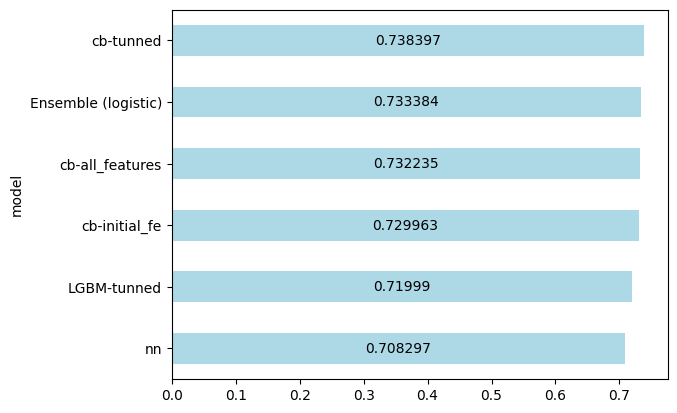

In [25]:
result_score = []
for label in scores.keys():
    result_score.append((label,np.mean(scores[label])))
ax = pd.DataFrame(result_score,columns=['model','score']).sort_values(by='score').set_index('model').plot(kind='barh',color='lightblue')
ax.bar_label(ax.containers[0],label_type='center');
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Submission

In [26]:
if submit:
    sub = pd.read_csv('/kaggle/input/nwds-batted-balls/sample_submission.csv')
    sub['out'] = test_pred['cb-tunned'][:,0]
    sub['single'] = test_pred['cb-tunned'][:,1]
    sub['double'] = test_pred['cb-tunned'][:,2]
    sub['triple'] = test_pred['cb-tunned'][:,3]
    sub['home_run'] = test_pred['cb-tunned'][:,4]
    sub.to_csv('submission.csv',index=False)
